In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from pathlib import Path
from typing import Literal

from matplotlib import pyplot as plt
from shapely.geometry import Point
from scipy.signal import find_peaks
import numpy as np

from s2shores.bathy_debug.temporal_correlation_bathy_estimator_debug import TemporalCorrelationBathyEstimatorDebug
from s2shores.bathy_physics import wavelength_offshore
from s2shores.generic_utils.image_filters import (
    circular_masking,
    clipping,
    detrend,
    gaussian_masking,
    normalise,
)
from s2shores.generic_utils.signal_filters import (
    butter_bandpass_filter,
    detrend_signal,
    filter_median,
)
from s2shores.generic_utils.signal_utils import find_period_from_zeros
from s2shores.generic_utils.symmetric_radon import symmetric_radon
from s2shores.image_processing.waves_radon import WavesRadon
from s2shores.image_processing.waves_sinogram import WavesSinogram
from s2shores.global_bathymetry.bathy_config import (
    BathyConfig,
    GlobalEstimatorConfig,
    TemporalCorrelationConfig,
    TemporalCorrelationTuningConfig,
)
from s2shores.waves_exceptions import WavesEstimationError, NotExploitableSinogram, SequenceImagesError
from utils import initialize_sequential_run, read_config

## Coastal Bathymetry Estimation via Temporal Correlation

This notebook implements a bathymetric method using satellite imagery based on **spatial correlation** and the **linear relationship between water depth and wave kinematics**.  
Wave kinematics are inferred through the **spatial correlation of the wave field**, measured from two satellite images acquired within a short time interval.  
By leveraging the theory of linear wave dispersion in shallow water, bathymetry can be estimated from the wavelength of the waves.

## Notebook Objective

This notebook provides an **experimental and interactive** environment to:
- explore and adjust the key processing steps,
- quickly test different parameters and method variations,
- support **iterative development** of the processing workflow in a prototyping context.
## Notebook Summary

1. **Preprocess the images**: Apply filters on the images.
2. **Find the direction**: Calculate the main propagation direction of the waves.
3. **Compute the Radon transforms**: Compute Radon transforms on all images.
4. **Compute the spatial correlation**: Compute the spatial correlations of the radon transform on the main direction.
5. **Compute the wavelength**: Compute the wavelength of the waves based on the period of the spatial correlation.
6. **Compute the delta position**: Compute the depth estimation from the wavelength.

In [93]:
base_path = Path("../TestsS2Shores").resolve()
test_case: Literal["7_4", "8_2"] = "7_4"
method: Literal["spatial_corr", "spatial_dft", "temporal_corr"] = "temporal_corr"

product_path: Path = base_path / "products" / f"SWASH_{test_case}/testcase_{test_case}.tif"
config_path: Path = base_path / f"reference_results/debug_pointswash_{method}/wave_bathy_inversion_config.yaml"
debug_file: Path = base_path / f"debug_points/debug_points_SWASH_{test_case}.yaml"

estimation_point = Point(451.0, 499.0)

In [94]:
# config = read_config(config_path=config_path)

# OR

config = BathyConfig(
    GLOBAL_ESTIMATOR=GlobalEstimatorConfig(
        WAVE_EST_METHOD='TEMPORAL_CORRELATION',
        SELECTED_FRAMES=None,
        OUTPUT_FORMAT='POINT',
        DXP=50.0,
        DYP=500.0,
        LAYERS_TYPE='EXPERT',
        NKEEP=5,
        OFFSHORE_LIMIT=100.0,
        WINDOW=400.0,
        SM_LENGTH=100,
        MIN_D=2.0,
        MIN_T=3.0,
        MAX_T=25.0,
        MIN_WAVES_LINEARITY=0.01,
        MAX_WAVES_LINEARITY=1.0,
        DEPTH_EST_METHOD='LINEAR',
    ),
    TEMPORAL_CORRELATION=TemporalCorrelationConfig(
        TEMPORAL_LAG=1,
        PERCENTAGE_POINTS=1.0,
        TUNING=TemporalCorrelationTuningConfig(
            DETREND_TIME_SERIES=0, FILTER_TIME_SERIES=0,
            LOWCUT_PERIOD=25.0,
            HIGHCUT_PERIOD=5.0,
            PEAK_DETECTION_HEIGHT_RATIO=0.3,
            PEAK_DETECTION_DISTANCE_RATIO=0.5,
            RATIO_SIZE_CORRELATION=1.0,
            MEAN_FILTER_KERNEL_SIZE_SINOGRAM=5,
            SIGMA_CORRELATION_MASK=2.0,
            MEDIAN_FILTER_KERNEL=5,
        )
    )
)

If you want to change any parameter of the configuration, modify the values of the object `config` by overriding the values of the attributes.  

Example:
```python
config.parameter = "new_value"
```

In [95]:
bathy_estimator, ortho_bathy_estimator, ortho_sequence = initialize_sequential_run(
    product_path=product_path,
    point=estimation_point,
    config=config,
)

/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42497 instead
  warnings.warn(


In [96]:
local_estimator = TemporalCorrelationBathyEstimatorDebug(
    estimation_point,
    ortho_sequence,
    bathy_estimator,
)

if not local_estimator.can_estimate_bathy():
    raise WavesEstimationError("Cannot estimate bathy.")

<Figure size 900x1400 with 0 Axes>

## Center point is out

In [ ]:
if False:
    local_estimator.center_pt_is_out()
else:
    merge_array = np.dstack([image.pixels for image in ortho_sequence])
    shape_y, shape_x = ortho_sequence.shape
    ts_mean = np.mean(merge_array[shape_y // 2, shape_x // 2, :])

    if not(np.isfinite(ts_mean)) or ts_mean == 0:
        raise SequenceImagesError('Window center pixel is out of border or has a 0 mean.')

## Preprocess images

Modified attributes:
- local_estimator.ortho_sequence.\<elements\>.pixels

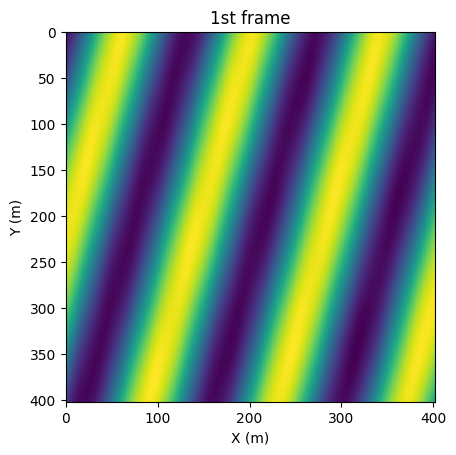

In [ ]:
if False:
    local_estimator.preprocess_images()
else:
    preprocessing_filters = [(normalise, [])]

    for image in local_estimator.ortho_sequence:
        filtered_image = image.apply_filters(preprocessing_filters)
        image.pixels = filtered_image.pixels
    
local_estimator.build_first_frame_plot()
plt.show()

## Create sequence time series

New attributes:
```python
- local_estimator._time_series
- local_estimator.metrics["detrend_time_series"]
- local_estimator.metrics["filtered_time_series"]
```

New attributes:
- local_estimator._time_series

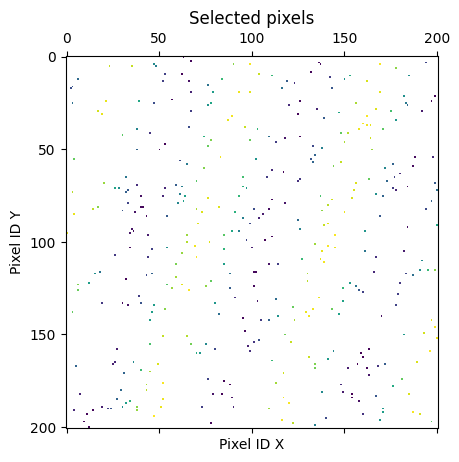

In [117]:
if False:
    local_estimator.create_sequence_time_series()
else:
    percentage_points = config.TEMPORAL_CORRELATION.PERCENTAGE_POINTS
    if percentage_points < 0 or percentage_points > 100:
        raise ValueError('Percentage must be between 0 and 100')

    # Create frame stack
    merge_array = np.dstack([image.pixels for image in ortho_sequence])

    # Select pixel positions randomly
    shape_y, shape_x = ortho_sequence.shape
    image_size = shape_x * shape_y
    local_estimator._time_series = np.reshape(merge_array, (image_size, -1))
    np.random.seed(0)  # A seed is used here to reproduce same results
    nb_random_points = round(image_size * percentage_points / 100)
    random_indexes = np.random.randint(image_size, size=nb_random_points)

    sampling_positions_x, sampling_positions_y = np.unravel_index(
        random_indexes, ortho_sequence.shape)
    local_estimator._sampling_positions = (np.reshape(sampling_positions_x, (1, -1)),
                                np.reshape(sampling_positions_y, (1, -1)))

    # Extract and detrend Time-series
    if config.TEMPORAL_CORRELATION.TUNING.DETREND_TIME_SERIES == 1:
        try:
            time_series_selec = detrend_signal(local_estimator._time_series[random_indexes, :], axis=1)
        except ValueError as excp:
            raise SequenceImagesError(
                'Time-series can not be computed because of the presence of nans') from excp
    elif config.TEMPORAL_CORRELATION.TUNING.DETREND_TIME_SERIES == 0:
        time_series_selec = local_estimator._time_series[random_indexes, :]
    else:
        raise ValueError('DETREND_TIME_SERIES parameter must be 0 or 1.')

    # BP filtering
    if config.TEMPORAL_CORRELATION.TUNING.FILTER_TIME_SERIES == 1:
        fps = 1 / local_estimator.sampling_period
        local_estimator._time_series = butter_bandpass_filter(
            time_series_selec,
            lowcut_period=config.TEMPORAL_CORRELATION.TUNING.LOWCUT_PERIOD,
            highcut_period=config.TEMPORAL_CORRELATION.TUNING.HIGHCUT_PERIOD,
            sampling_freq=fps,
            axis=1)
    elif config.TEMPORAL_CORRELATION.TUNING.FILTER_TIME_SERIES == 0:
        local_estimator._time_series = time_series_selec
    else:
        raise ValueError('FILTER_TIME_SERIES parameter must be 0 or 1.')


    local_estimator.metrics['detrend_time_series'] = time_series_selec[0, :]
    local_estimator.metrics['filtered_time_series'] = local_estimator._time_series[0, :]


local_estimator.build_first_frame_selection_plot()
plt.show()

## Compute temporal correlation

**USE correlation_image OR local_estimator.correlation_image ?**

New attributes:
```python
- local_estimator.sinogram_maxvar
- local_estimator.metrics["corr_indices_x"]
- local_estimator.metrics["corr_indices_y"]
- local_estimator.metrics["projected_corr_raw"]
- local_estimator.metrics["corr_radon_input"]
```

New variables:
- correlation_image

In [ ]:
import pandas
from s2shores.image_processing.waves_image import WavesImage

indices_x = np.round(local_estimator.distances * np.cos(local_estimator.angles))
indices_x = np.array(indices_x - np.min(indices_x), dtype=int).T

indices_y = np.round(local_estimator.distances * np.sin(local_estimator.angles))
indices_y = np.array(indices_y - np.min(indices_y), dtype=int).T

# if two correlation values have same xr and yr mean of these values is taken
dataframe = pandas.DataFrame({
    'xr': indices_x.flatten(),
    'yr': indices_y.flatten(),
    'values': local_estimator.correlation_matrix.flatten(),
})
dataframe_grouped = dataframe.groupby(by=['xr', 'yr']).mean().reset_index()
values = dataframe_grouped['values'].values
indices_x = dataframe_grouped['xr'].values
indices_y = dataframe_grouped['yr'].values

projected_matrix = np.nanmean(local_estimator.correlation_matrix) * np.ones(
    (np.max(indices_x) + 1, np.max(indices_y) + 1))
projected_matrix[indices_x, indices_y] = values

local_estimator.metrics['corr_indices_x'] = indices_x
local_estimator.metrics['corr_indices_y'] = indices_y
local_estimator.metrics['projected_corr_raw'] = projected_matrix

correlation_image = WavesImage(projected_matrix, local_estimator.spatial_resolution)

local_estimator.build_correlation_matrix_plot()
plt.show()

In [ ]:
if False:
    local_estimator.compute_temporal_correlation()
    correlation_image = local_estimator.correlation_image
else:
    correlation_image_filters = [
        (detrend, []),
        (gaussian_masking, [config.TEMPORAL_CORRELATION.TUNING.SIGMA_CORRELATION_MASK]),
        (clipping, [config.TEMPORAL_CORRELATION.TUNING.RATIO_SIZE_CORRELATION]),
    ]

    correlation_image = correlation_image.apply_filters(correlation_image_filters)

local_estimator.metrics['corr_radon_input'] = correlation_image.pixels
local_estimator.build_correlation_matrix_filled_filtered()
plt.show()

## Compute radon transform

New attributes:
```python
- local_estimator.sinogram_maxvar
- local_estimator.metrics["radon_transform"]
- local_estimator.metrics["variances"]
- local_estimator.metrics["direction"]
- local_estimator.metrics["sinogram_max_var"]
```

New variables:
- direction_propagation

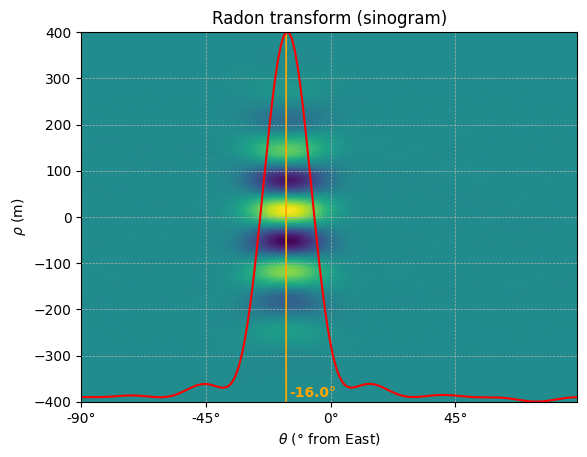

In [114]:
if False:
    direction_propagation = local_estimator.compute_radon_transform()
else:
    # Start: WavesRadon(local_estimator.correlation_image, local_estimator.selected_directions)
    sampling_frequency = 1. / correlation_image.resolution

    pixels = circular_masking(image.pixels.copy())
    radon_transform = symmetric_radon(image=pixels, theta=local_estimator.selected_directions)

    local_estimator.radon_transform = {
        direction: radon_transform[:, idx]
        for idx, direction in enumerate(local_estimator.selected_directions)
    }
    # End: WavesRadon(local_estimator.correlation_image, local_estimator.selected_directions)

    # Start: WavesRadon.get_direction_maximum_variance()

    # Start: Sinograms.get_sinograms_variances(selected_directions)
    variances = np.empty(len(local_estimator.selected_directions), dtype=np.float64)
    for result_index, direction in enumerate(local_estimator.selected_directions):
        variances[result_index] = float(np.var(local_estimator.radon_transform[direction]))
    # End: Sinograms.get_sinograms_variances

    index_max_variance = np.argmax(variances)
    direction_propagation = local_estimator.selected_directions[index_max_variance]
    # End: WavesRadon.get_direction_maximum_variance

    # Extract projected sinogram at max var ang from sinogram
    sinogram_maxvar = local_estimator.radon_transform[direction_propagation]


    # Median filtering of the projected sinogram
    sinogram_max_var_filters = [
        (filter_median, [config.TEMPORAL_CORRELATION.TUNING.MEDIAN_FILTER_KERNEL]),
    ]

    for filter, filter_params in sinogram_max_var_filters:
        sinogram_maxvar = filter(sinogram_maxvar, *filter_params)

    local_estimator.sinogram_maxvar = WavesSinogram(sinogram_maxvar)
    local_estimator.metrics['radon_transform'] = WavesRadon(correlation_image, local_estimator.selected_directions)
    local_estimator.metrics['variances'] = variances
    local_estimator.metrics['direction'] = direction_propagation
    local_estimator.metrics['sinogram_max_var'] = sinogram_maxvar

local_estimator.build_radon_matrix_plot()
plt.show()

## Compute wavelength

New attributes:
```python
- local_estimator.metrics["wave_spatial_zeros"]
```

New variables:
- wave_length
- wave_length_wavelength_zeros

In [116]:
if True:
    wavelength, wavelength_zeros = local_estimator.compute_wavelength()
else:
    min_wavelength = wavelength_offshore(local_estimator.global_estimator.waves_period_min, local_estimator.gravity)
    try:
        period, wavelength_zeros = find_period_from_zeros(
            sinogram_maxvar,
            int(min_wavelength / local_estimator.spatial_resolution),
        )
    except ValueError as excp:
        raise NotExploitableSinogram('Wave length can not be computed from sinogram') from excp
    wavelength = period * local_estimator.spatial_resolution

    local_estimator.metrics['wave_spatial_zeros'] = wavelength_zeros * local_estimator.spatial_resolution

wavelength

135.39227597017458

## Compute distances

New attributes:
```python
- local_estimator.metrics["max_indices"]
- local_estimator.metrics["wave_distance"]
```

New variables:
- distances

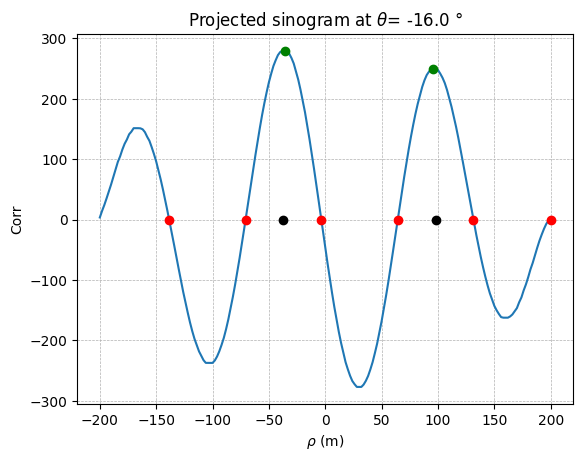

In [ ]:
if False:
    distances = self.compute_distance(wavelength, wavelength_zeros)
else:
    x_axis = np.arange(0, len(sinogram_maxvar)) - (len(sinogram_maxvar) // 2)
    period = int(wavelength / local_estimator.spatial_resolution)
    max_sinogram = np.max(sinogram_maxvar[(x_axis >= wavelength_zeros[0]) & (x_axis < wavelength_zeros[-1])])

    # Find peaks
    tuning_parameters = local_estimator.local_estimator_params['TUNING']
    peaks, _ = find_peaks(
        sinogram_maxvar[(x_axis >= wavelength_zeros[0]) & (x_axis < wavelength_zeros[-1])],
        height=tuning_parameters['PEAK_DETECTION_HEIGHT_RATIO'] *
        max_sinogram,
        distance=tuning_parameters['PEAK_DETECTION_DISTANCE_RATIO'] * period,
    )

    # Compute initial distance
    dx_in_list = x_axis[(x_axis >= wavelength_zeros[0]) & (x_axis < wavelength_zeros[-1])][peaks]
    distances = []

    for dx_in in dx_in_list:
        # Find 0-crossing surrounding the peak
        zeros_right = wavelength_zeros[wavelength_zeros > dx_in][0]
        zeros_left = wavelength_zeros[wavelength_zeros <= dx_in][-1]

        # Refine distance
        ref = [zeros_right, zeros_left][np.argmin(np.abs([zeros_right, zeros_left]))]
        offset = np.sign(dx_in - ref) * (np.abs(zeros_left - zeros_right) / 2)
        distance = ref + offset
        distances.append(distance)

    # Distance of the wave propagation
    distances = np.array(distances) * local_estimator.spatial_resolution

    local_estimator.metrics['max_indices'] = peaks
    local_estimator.metrics['wave_distance'] = distances

    local_estimator.build_sinogram_plot()
    plt.show()

## Save wave field estimation

New elements:
- local_estimator.bathymetry_estimations

In [109]:
if False:
    local_estimator.save_wave_field_estimation(direction_propagation, wavelength, distances)
else:
    for i, distance in enumerate(distances):
        bathymetry_estimation = local_estimator.create_bathymetry_estimation(
            direction_propagation,
            wavelength,
        )
        bathymetry_estimation.delta_position = distance
        local_estimator.bathymetry_estimations.append(bathymetry_estimation)

        print(
            f"\033[4mDistance n°{i}:\033[0m",
            f"Physical: {bathymetry_estimation.is_physical()}",
            bathymetry_estimation,
            "\n",
            sep="\n",
        )

    local_estimator.bathymetry_estimations.sort_on_attribute('linearity', reverse=False)

    local_estimator.metrics['bathymetry_estimation'] = local_estimator.bathymetry_estimations
    local_estimator.metrics['status'] = local_estimator.bathymetry_estimations.status


Distance n°0:
Physical: False
Geometry:   direction: 164.0° wavelength: 135.39 (m) wavenumber: 0.007386 (m-1)
Dynamics:   period:  3.65 (s)  celerity: 37.12 (m/s)
Wave Field Estimation: 
  delta time: 1.000 (s) stroboscopic factor: 0.274 (unitless)
  delta position: 37.12 (m)  delta phase:  1.72 (rd)
Bathymetry inversion: depth:   inf (m)  gamma: 6.539  offshore period:  9.33 (s)  shallow water period: 30.61 (s)  relative period:  2.56  relative wavelength:  0.15  gravity: 9.780 (s) 
Bathymetry Estimation:  stroboscopic factor low depth: 0.033  stroboscopic factor offshore: 0.107 


Distance n°1:
Physical: False
Geometry:   direction: -16.0° wavelength: 135.39 (m) wavenumber: 0.007386 (m-1)
Dynamics:   period:  1.38 (s)  celerity: 97.83 (m/s)
Wave Field Estimation: 
  delta time: 1.000 (s) stroboscopic factor: 0.723 (unitless)
  delta position: 97.83 (m)  delta phase:  4.54 (rd)
Bathymetry inversion: depth:   inf (m)  gamma: 45.413  offshore period:  9.33 (s)  shallow water period: 30.

/home/geoffrey/Projets-Linux/CNES/s2shores/src/s2shores/data_model/bathymetry_sample_estimations.py:71: UserWarning: 
Trying to store a duplicate estimation:
Geometry:   direction: 164.0° wavelength: 135.39 (m) wavenumber: 0.007386 (m-1)
Dynamics:   period:  3.65 (s)  celerity: 37.12 (m/s)
Wave Field Estimation: 
  delta time: 1.000 (s) stroboscopic factor: 0.274 (unitless)
  delta position: 37.12 (m)  delta phase:  1.72 (rd)
Bathymetry inversion: depth:   inf (m)  gamma: 6.539  offshore period:  9.33 (s)  shallow water period: 30.61 (s)  relative period:  2.56  relative wavelength:  0.15  gravity: 9.780 (s) 
Bathymetry Estimation:  stroboscopic factor low depth: 0.033  stroboscopic factor offshore: 0.107  
  warnings.warn(f'\nTrying to store a duplicate estimation:\n{str(estimation)} ')
/home/geoffrey/Projets-Linux/CNES/s2shores/src/s2shores/data_model/bathymetry_sample_estimations.py:71: UserWarning: 
Trying to store a duplicate estimation:
Geometry:   direction: -16.0° wavelength: 1